This is not my work and is an example taken from PyPSA.

It does provide some great insight into the work that can be done using PyPSA

Link: https://pypsa.readthedocs.io/en/latest/examples/scigrid-lopf-then-pf.html

In [1]:
import pypsa
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [2]:
network = pypsa.examples.scigrid_de(from_master=True)

INFO:pypsa.io:Imported network scigrid-de.nc has buses, generators, lines, loads, storage_units, transformers


c:\Users\Ben\Documents\GitHub\ELEC457---Final-Project\venv\lib\site-packages\cartopy\mpl\style.py:76: UserWarning:

facecolor will have no effect as it has been defined as "never".



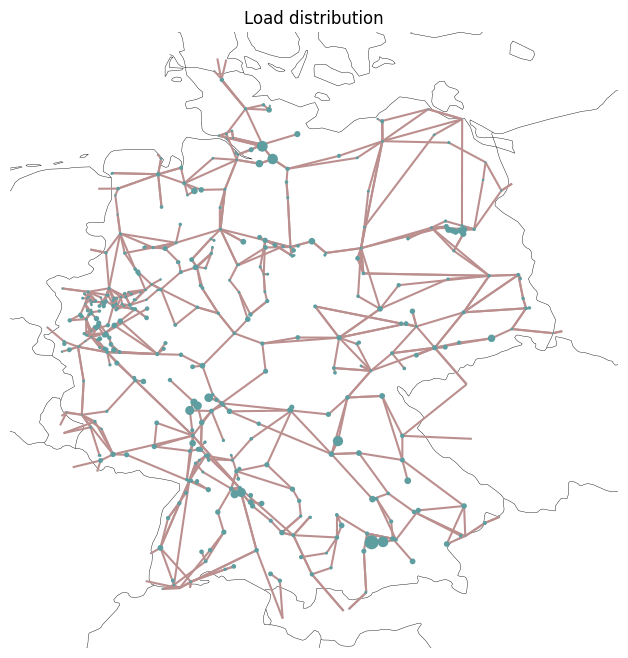

In [3]:
fig, ax = plt.subplots(
    1, 1, subplot_kw={"projection": ccrs.EqualEarth()}, figsize=(8, 8)
)

load_distribution = (
    network.loads_t.p_set.loc[network.snapshots[0]].groupby(network.loads.bus).sum()
)
network.plot(bus_sizes=1e-5 * load_distribution, ax=ax, title="Load distribution");

In [4]:
network.generators.groupby("carrier")["p_nom"].sum()

carrier
Brown Coal       20879.500000
Gas              23913.130000
Geothermal          31.700000
Hard Coal        25312.600000
Multiple           152.700000
Nuclear          12068.000000
Oil               2710.200000
Other             3027.800000
Run of River      3999.100000
Solar            37041.524779
Storage Hydro     1445.000000
Waste             1645.900000
Wind Offshore     2973.500000
Wind Onshore     37339.895329
Name: p_nom, dtype: float64

In [5]:
network.storage_units.groupby("carrier")["p_nom"].sum()

carrier
Pumped Hydro    9179.5
Name: p_nom, dtype: float64

c:\Users\Ben\Documents\GitHub\ELEC457---Final-Project\venv\lib\site-packages\cartopy\mpl\style.py:76: UserWarning:

facecolor will have no effect as it has been defined as "never".



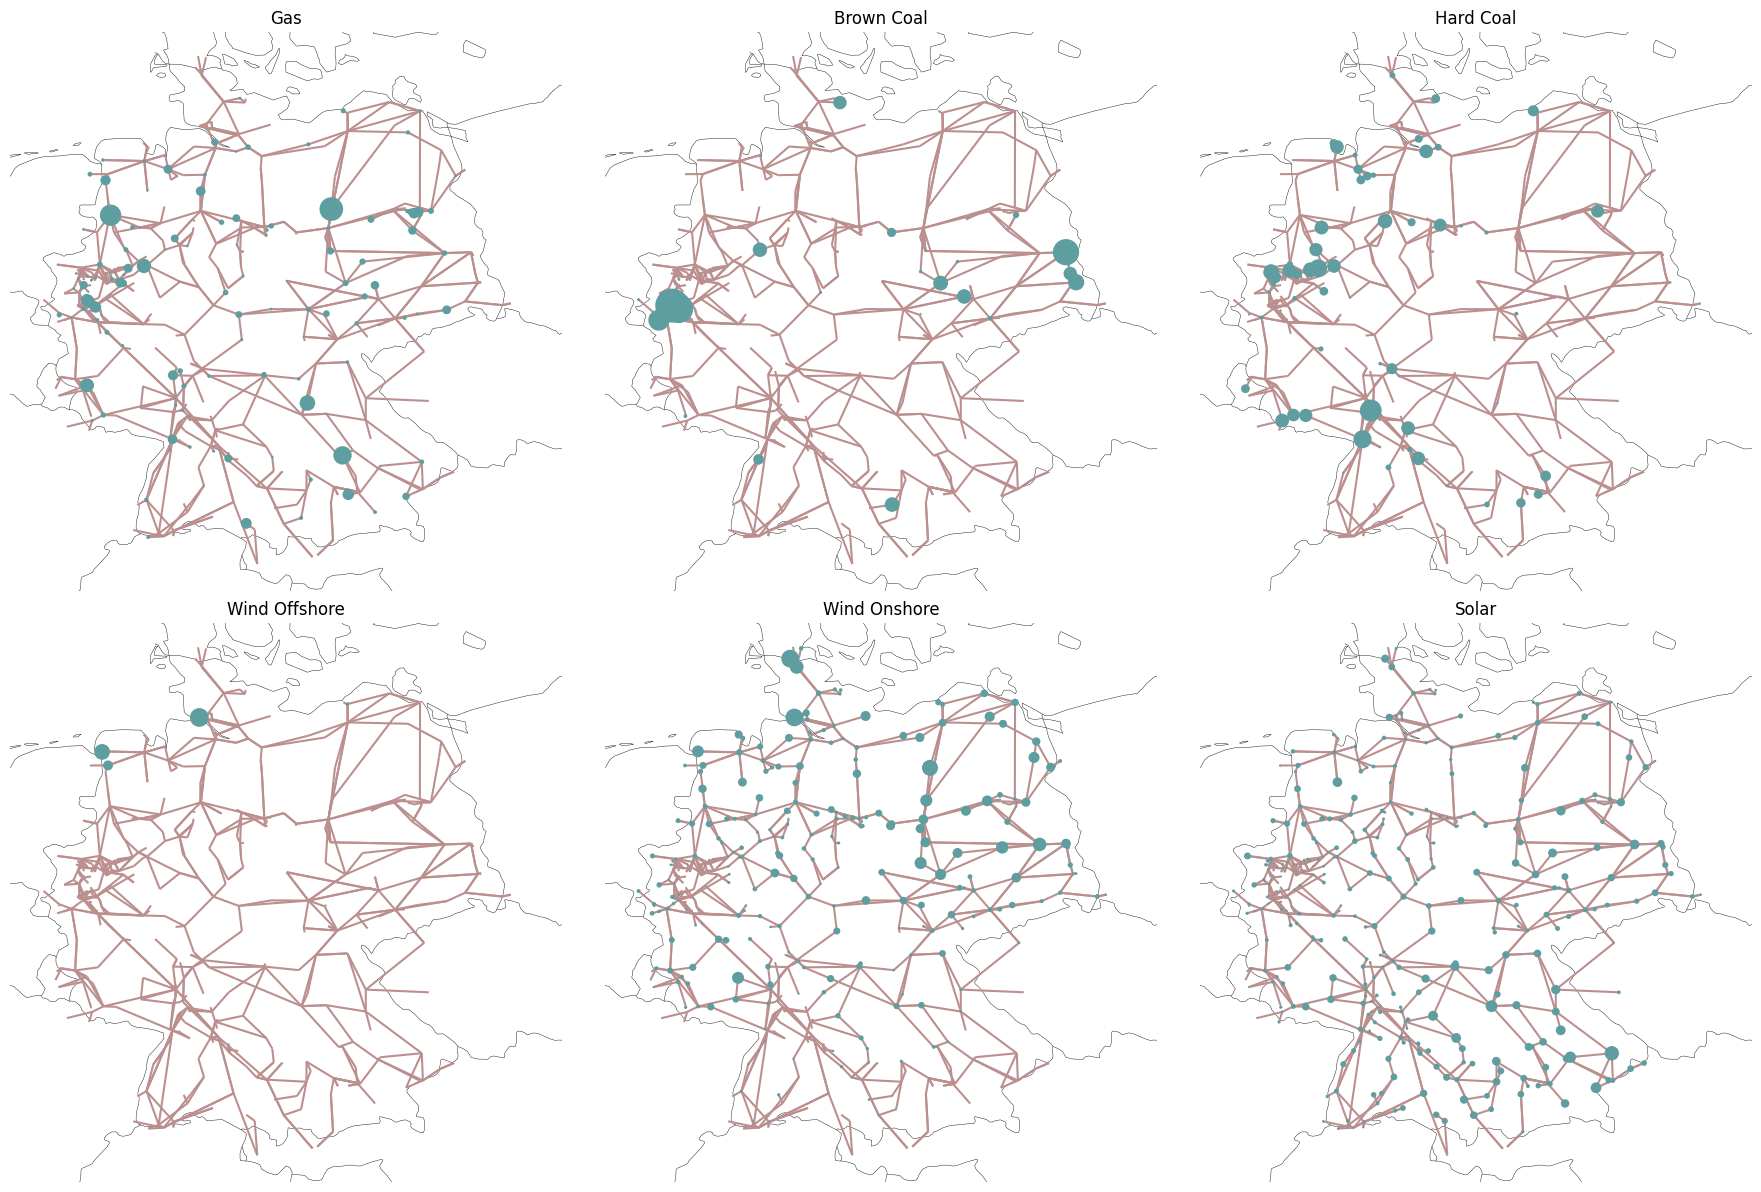

In [6]:
techs = ["Gas", "Brown Coal", "Hard Coal", "Wind Offshore", "Wind Onshore", "Solar"]

n_graphs = len(techs)
n_cols = 3
if n_graphs % n_cols == 0:
    n_rows = n_graphs // n_cols
else:
    n_rows = n_graphs // n_cols + 1


fig, axes = plt.subplots(
    nrows=n_rows, ncols=n_cols, subplot_kw={"projection": ccrs.EqualEarth()}
)
size = 6
fig.set_size_inches(size * n_cols, size * n_rows)

for i, tech in enumerate(techs):
    i_row = i // n_cols
    i_col = i % n_cols

    ax = axes[i_row, i_col]
    gens = network.generators[network.generators.carrier == tech]
    gen_distribution = (
        gens.groupby("bus").sum()["p_nom"].reindex(network.buses.index, fill_value=0.0)
    )
    network.plot(ax=ax, bus_sizes=2e-5 * gen_distribution)
    ax.set_title(tech)
fig.tight_layout()

In [7]:
contingency_factor = 0.7
network.lines.s_max_pu = contingency_factor

In [8]:
network.lines.loc[["316", "527", "602"], "s_nom"] = 1715

In [9]:
group_size = 4
network.storage_units.state_of_charge_initial = 0.0

for i in range(int(24 / group_size)):
    # set the initial state of charge based on previous round
    if i:
        network.storage_units.state_of_charge_initial = (
            network.storage_units_t.state_of_charge.loc[
                network.snapshots[group_size * i - 1]
            ]
        )
    network.optimize(
        network.snapshots[group_size * i : group_size * i + group_size],
        solver_name="highs",
    )

Index(['2', '5', '10', '12', '13', '15', '18', '20', '22', '24', '26', '30',
       '32', '37', '42', '46', '52', '56', '61', '68', '69', '74', '78', '86',
       '87', '94', '95', '96', '99', '100', '104', '105', '106', '107', '117',
       '120', '123', '124', '125', '128', '129', '138', '143', '156', '157',
       '159', '160', '165', '184', '191', '195', '201', '220', '231', '232',
       '233', '236', '247', '248', '250', '251', '252', '261', '263', '264',
       '267', '272', '279', '281', '282', '292', '303', '307', '308', '312',
       '315', '317', '322', '332', '334', '336', '338', '351', '353', '360',
       '362', '382', '384', '385', '391', '403', '404', '413', '421', '450',
       '458'],
      dtype='object', name='Transformer')


Index(['2', '5', '10', '12', '13', '15', '18', '20', '22', '24', '26', '30',
       '32', '37', '42', '46', '52', '56', '61', '68', '69', '74', '78', '86',
       '87', '94', '95', '96', '99', '100', '104', '105', '106', '107', '117',
       '120', '123', '124', '125', '128', '129', '138', '143', '156', '157',
       '159', '160', '165', '184', '191', '195', '201', '220', '231', '232',
       '233', '236', '247', '248', '250', '251', '252', '261', '263', '264',
       '267', '272', '279', '281', '282', '292', '303', '307', '308', '312',
       '315', '317', '322', '332', '334', '336', '338', '351', '353', '360',
       '362', '382', '384', '385', '391', '403', '404', '413', '421', '450',
       '458'],
      dtype='object', name='Transformer')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 368.39it/s]
INFO:linopy.io: Writing time: 0.17s
INFO:linopy.solvers:Log file at C:\Users\Ben\A

In [10]:
p_by_carrier = network.generators_t.p.groupby(network.generators.carrier, axis=1).sum()
p_by_carrier.drop(
    (p_by_carrier.max()[p_by_carrier.max() < 1700.0]).index, axis=1, inplace=True
)
p_by_carrier.columns

Index(['Brown Coal', 'Gas', 'Hard Coal', 'Nuclear', 'Run of River', 'Solar',
       'Wind Offshore', 'Wind Onshore'],
      dtype='object', name='carrier')

In [11]:
colors = {
    "Brown Coal": "brown",
    "Hard Coal": "k",
    "Nuclear": "r",
    "Run of River": "green",
    "Wind Onshore": "blue",
    "Solar": "yellow",
    "Wind Offshore": "cyan",
    "Waste": "orange",
    "Gas": "orange",
}
# reorder
cols = [
    "Nuclear",
    "Run of River",
    "Brown Coal",
    "Hard Coal",
    "Gas",
    "Wind Offshore",
    "Wind Onshore",
    "Solar",
]
p_by_carrier = p_by_carrier[cols]

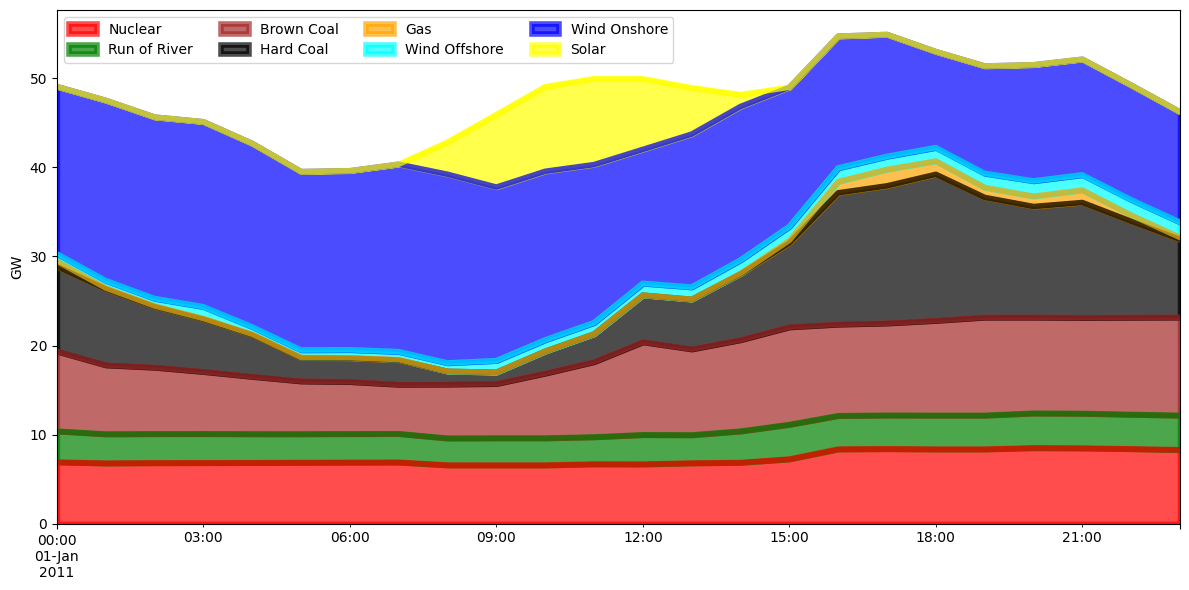

In [12]:
c = [colors[col] for col in p_by_carrier.columns]

fig, ax = plt.subplots(figsize=(12, 6))
(p_by_carrier / 1e3).plot(kind="area", ax=ax, linewidth=4, color=c, alpha=0.7)
ax.legend(ncol=4, loc="upper left")
ax.set_ylabel("GW")
ax.set_xlabel("")
fig.tight_layout()

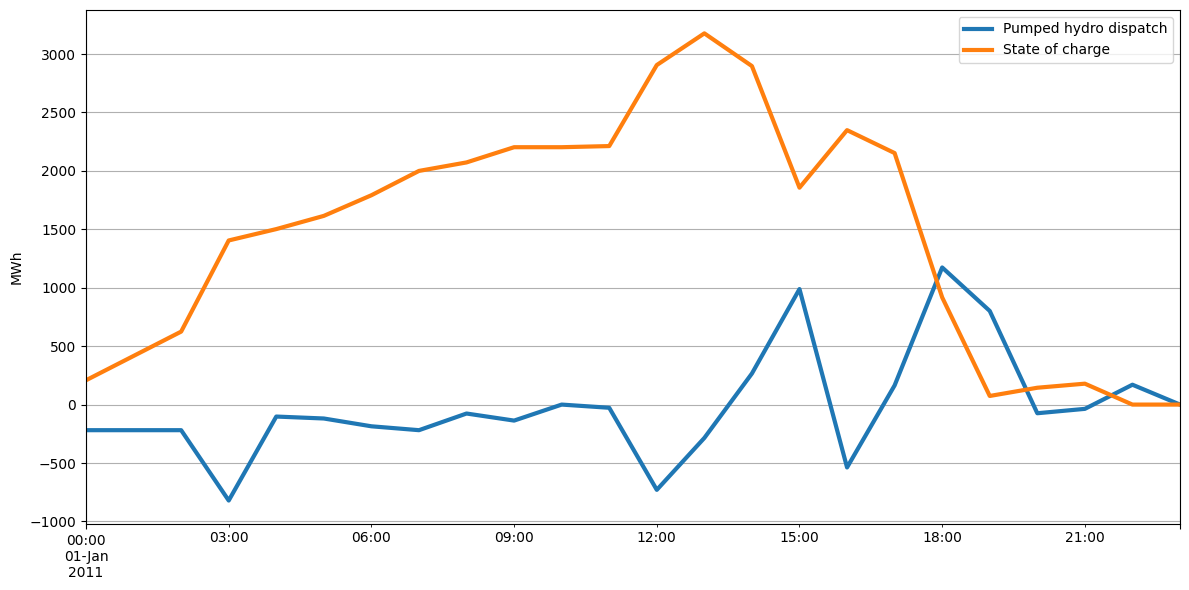

In [13]:
fig, ax = plt.subplots(figsize=(12, 6))

p_storage = network.storage_units_t.p.sum(axis=1)
state_of_charge = network.storage_units_t.state_of_charge.sum(axis=1)
p_storage.plot(label="Pumped hydro dispatch", ax=ax, linewidth=3)
state_of_charge.plot(label="State of charge", ax=ax, linewidth=3)

ax.legend()
ax.grid()
ax.set_ylabel("MWh")
ax.set_xlabel("")
fig.tight_layout()

In [14]:
now = network.snapshots[4]

In [15]:
loading = network.lines_t.p0.loc[now] / network.lines.s_nom
loading.describe()

count    852.000000
mean      -0.003145
std        0.260237
min       -0.700000
25%       -0.128281
50%        0.003209
75%        0.121985
max        0.700000
dtype: float64

c:\Users\Ben\Documents\GitHub\ELEC457---Final-Project\venv\lib\site-packages\cartopy\mpl\style.py:76: UserWarning:

facecolor will have no effect as it has been defined as "never".



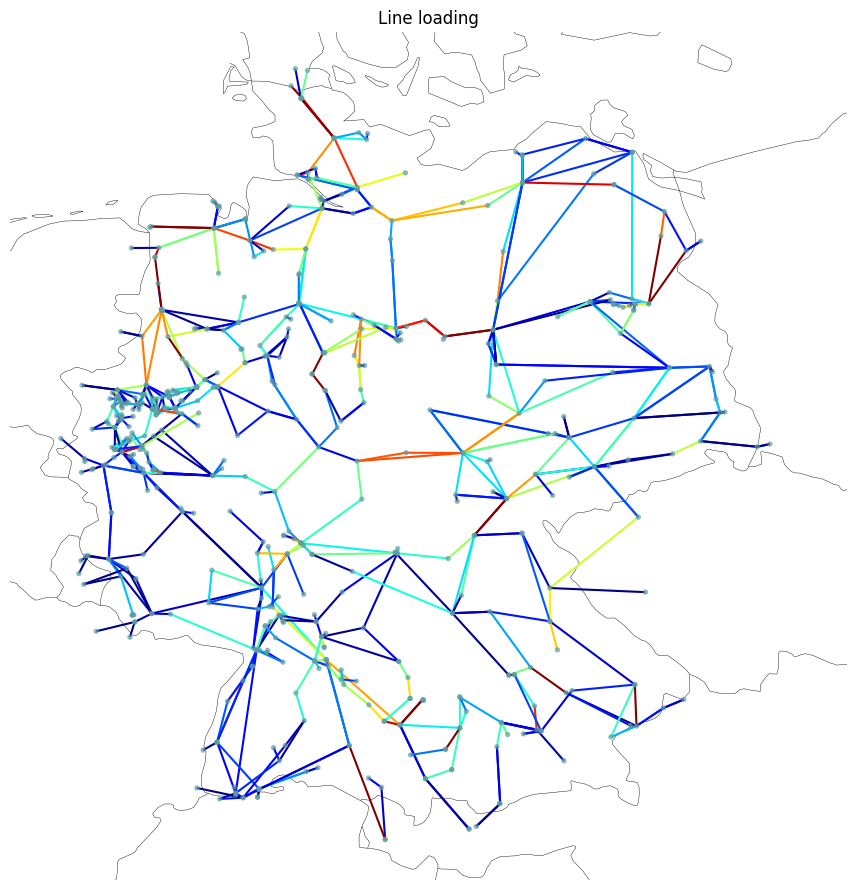

In [16]:
fig, ax = plt.subplots(subplot_kw={"projection": ccrs.EqualEarth()}, figsize=(9, 9))
network.plot(
    ax=ax,
    line_colors=abs(loading),
    line_cmap=plt.cm.jet,
    title="Line loading",
    bus_sizes=1e-3,
    bus_alpha=0.7,
)
fig.tight_layout();

In [17]:
network.buses_t.marginal_price.loc[now].describe()

count    585.000000
mean      15.737598
std       10.941995
min      -10.397824
25%        6.992120
50%       15.841190
75%       25.048186
max       52.150120
Name: 2011-01-01 04:00:00, dtype: float64

c:\Users\Ben\Documents\GitHub\ELEC457---Final-Project\venv\lib\site-packages\cartopy\mpl\style.py:76: UserWarning:

facecolor will have no effect as it has been defined as "never".



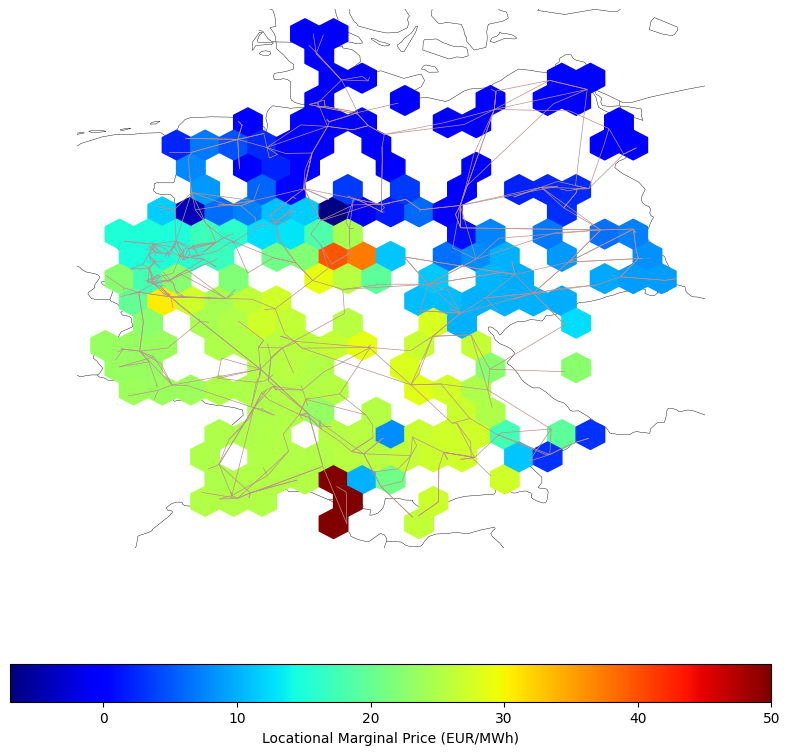

In [18]:
fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()}, figsize=(8, 8))

plt.hexbin(
    network.buses.x,
    network.buses.y,
    gridsize=20,
    C=network.buses_t.marginal_price.loc[now],
    cmap=plt.cm.jet,
    zorder=3,
)
network.plot(ax=ax, line_widths=pd.Series(0.5, network.lines.index), bus_sizes=0)

cb = plt.colorbar(location="bottom")
cb.set_label("Locational Marginal Price (EUR/MWh)")
fig.tight_layout()

In [19]:
carrier = "Wind Onshore"

capacity = network.generators.groupby("carrier").sum().at[carrier, "p_nom"]
p_available = network.generators_t.p_max_pu.multiply(network.generators["p_nom"])
p_available_by_carrier = p_available.groupby(network.generators.carrier, axis=1).sum()
p_curtailed_by_carrier = p_available_by_carrier - p_by_carrier

In [20]:
p_df = pd.DataFrame(
    {
        carrier + " available": p_available_by_carrier[carrier],
        carrier + " dispatched": p_by_carrier[carrier],
        carrier + " curtailed": p_curtailed_by_carrier[carrier],
    }
)

p_df[carrier + " capacity"] = capacity

In [21]:
p_df["Wind Onshore curtailed"][p_df["Wind Onshore curtailed"] < 0.0] = 0.0

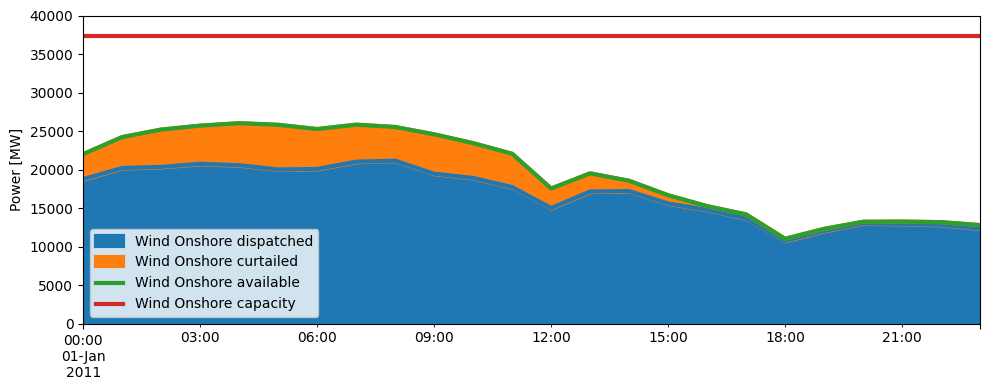

In [22]:
fig, ax = plt.subplots(figsize=(10, 4))
p_df[[carrier + " dispatched", carrier + " curtailed"]].plot(
    kind="area", ax=ax, linewidth=3
)
p_df[[carrier + " available", carrier + " capacity"]].plot(ax=ax, linewidth=3)

ax.set_xlabel("")
ax.set_ylabel("Power [MW]")
ax.set_ylim([0, 40000])
ax.legend()
fig.tight_layout()

In [23]:
network.generators_t.p_set = network.generators_t.p
network.storage_units_t.p_set = network.storage_units_t.p

In [24]:
network.generators.control = "PV"

# Need some PQ buses so that Jacobian doesn't break
f = network.generators[network.generators.bus == "492"]
network.generators.loc[f.index, "control"] = "PQ"

In [25]:
info = network.pf();

INFO:pypsa.pf:Performing non-linear load-flow on AC sub-network SubNetwork 0 for snapshots DatetimeIndex(['2011-01-01 00:00:00', '2011-01-01 01:00:00',
               '2011-01-01 02:00:00', '2011-01-01 03:00:00',
               '2011-01-01 04:00:00', '2011-01-01 05:00:00',
               '2011-01-01 06:00:00', '2011-01-01 07:00:00',
               '2011-01-01 08:00:00', '2011-01-01 09:00:00',
               '2011-01-01 10:00:00', '2011-01-01 11:00:00',
               '2011-01-01 12:00:00', '2011-01-01 13:00:00',
               '2011-01-01 14:00:00', '2011-01-01 15:00:00',
               '2011-01-01 16:00:00', '2011-01-01 17:00:00',
               '2011-01-01 18:00:00', '2011-01-01 19:00:00',
               '2011-01-01 20:00:00', '2011-01-01 21:00:00',
               '2011-01-01 22:00:00', '2011-01-01 23:00:00'],
              dtype='datetime64[ns]', name='snapshot', freq=None)
INFO:pypsa.pf:Newton-Raphson solved in 4 iterations with error of 0.000000 in 0.027001 seconds
INFO:pypsa.pf:N

In [26]:
(~info.converged).any().any()

False

In [27]:
(network.lines_t.p0.loc[now] / network.lines.s_nom).describe()

count    852.000000
mean       0.000226
std        0.262545
min       -0.813767
25%       -0.123980
50%        0.003103
75%        0.123851
max        0.827600
dtype: float64

In [28]:
df = network.lines.copy()

for b in ["bus0", "bus1"]:
    df = pd.merge(
        df, network.buses_t.v_ang.loc[[now]].T, how="left", left_on=b, right_index=True
    )

s = df[str(now) + "_x"] - df[str(now) + "_y"]

(s * 180 / np.pi).describe()

count    852.000000
mean      -0.022249
std        2.386780
min      -12.158079
25%       -0.465772
50%        0.001604
75%        0.534861
max       17.959258
dtype: float64

c:\Users\Ben\Documents\GitHub\ELEC457---Final-Project\venv\lib\site-packages\cartopy\mpl\style.py:76: UserWarning:

facecolor will have no effect as it has been defined as "never".



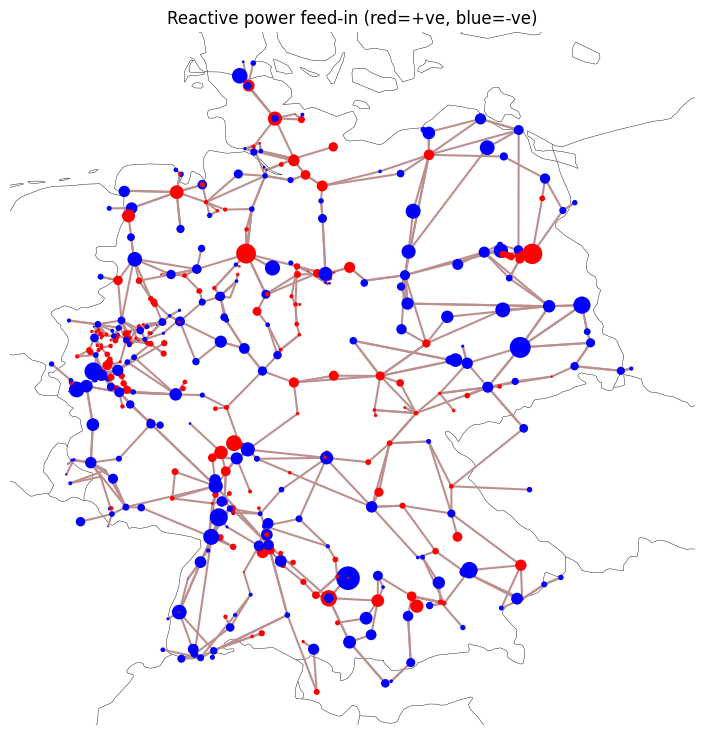

In [29]:
fig, ax = plt.subplots(subplot_kw={"projection": ccrs.EqualEarth()}, figsize=(9, 9))

q = network.buses_t.q.loc[now]
bus_colors = pd.Series("r", network.buses.index)
bus_colors[q < 0.0] = "b"

network.plot(
    bus_sizes=1e-4 * abs(q),
    ax=ax,
    bus_colors=bus_colors,
    title="Reactive power feed-in (red=+ve, blue=-ve)",
);